#### Intro

This is a test using deep convolutional generative adversarial networks implemented in Tensorflow 2.0 to generate cat face pictures.

#### Installing Tensorflow 2.0

In [0]:
%%capture
!pip install tensorflow-gpu==2.0.0-alpha0

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.version.VERSION

'2.0.0-alpha0'

#### Load image data

In [0]:
!pip install pydrive

# IMPORTS AND PREPARATION
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
def authenticate():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

In [0]:
drive = authenticate()
cats = drive.CreateFile({'id': 'google drive file id'})
cats.GetContentFile('cats.zip')

In [0]:
import os
import glob
import zipfile
import time

In [0]:
zip_ref = zipfile.ZipFile('cats.zip', 'r')
zip_ref.extractall('cats/')
zip_ref.close()

#### Preprocessing Cat Images

Since we are training the GAN to produce cat faces, we will extract out all the cat faces from the very conveniently labelled cat dataset.

In [0]:
import cv2
import math
import numpy as np

# Function to read image using OpenCV 2 and coordinates data
def read_img(filepath):
  f = open(filepath + ".cat")
  coordinates = [int(c) for c in f.read().strip().split(" ")]
  f.close()
  
  im = cv2.imread(filepath)
  return im, coordinates

The labelled data contain the cat eyes coordinates and ears. The points we are interested in are the eyes and the ear tips, as shown below.

Coordinates: [9, 251, 477, 463, 489, 360, 672, 104, 350, 141, 110, 280, 269, 451, 282, 634, 144, 612, 394]


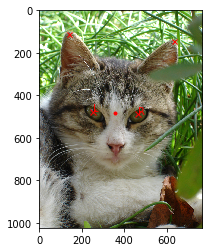

In [0]:
# Example for the image below:
im, coords = read_img("cats/CAT_01/00000100_002.jpg")

print("Coordinates:", coords)

im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(im_rgb)
# Left eye
plt.plot(coords[1], coords[2], 'rx')
plt.text(coords[1], coords[2], 'L', color="red")
# Right eye
plt.plot(coords[3], coords[4], 'rx')
plt.text(coords[3], coords[4], 'R', color="red")

plt.plot(coords[9], coords[10], 'rx', markersize=5)
plt.plot(coords[15], coords[16], 'rx', markersize=5)

# Obtain center of face (between cat eyes)
center_x = (coords[1] + coords[3])/2
center_y = (coords[2] + coords[4])/2
plt.plot(center_x, center_y, 'ro', markersize=3)
plt.show()

We then rotate the image such that the eyes are perfectly horizontal. 

Angle to rotate image is 3.23970029610213


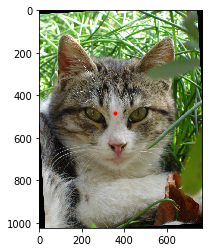

In [0]:
# ROTATION TEST
# Obtain angle of rotation (between horizontal and eyeline).
# Note: angle of horizontal is 0 degrees.
angle = math.atan2(coords[4]-coords[2], coords[3]-coords[1])
angle = math.degrees(angle)
if angle < 0: angle += 360
print("Angle to rotate image is", angle)

# Center of face is used as rotation pivot point.
rotation_matrix = cv2.getRotationMatrix2D((center_x, center_y), angle, 1)
im_rotated = cv2.warpAffine(im, rotation_matrix, im.shape[1::-1], flags=cv2.INTER_LINEAR)

im_rotated_rgb = cv2.cvtColor(im_rotated, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(im_rotated_rgb)
plt.plot(center_x, center_y, 'ro', markersize=3)
plt.show()

Finally, we crop the face out using the width of the ears with an extra 20% margin

Width of cat face is 593
Bounding box is x1=60 y1=186 x2=653 y2=779


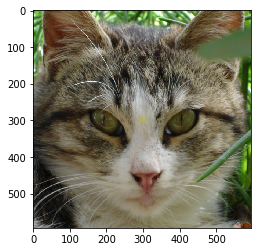

In [0]:
# CROP TEST
# Obtain width of image (between ear tips). Extended by 20% to hopefully contain the ear tips themselves
width = round(1.2*math.sqrt((coords[9] - coords[15])**2 + (coords[10] - coords[16])**2))
print("Width of cat face is", width)

img_height, img_width = im_rotated.shape[:2]

# Crop square bounding box using center and width
start_x = min(max(round(center_x - width/2), 0), img_width)
start_y = min(max(round(center_y - width/2), 0), img_height)
print("Bounding box is x1={} y1={} x2={} y2={}".format(start_x, start_y, start_x+width, start_y+width))
im_cropped = im_rotated[start_y : start_y + width + 1, start_x : start_x + width + 1]
im_cropped_rgb = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(im_cropped_rgb)
# Cat face center is now the true center of image
plt.plot(im_cropped.shape[0]/2, im_cropped.shape[1]/2, 'yx', markersize=8)
plt.show()

**Running the image preprocessing function over all the images**

In [0]:
def extract_cat_face(filepath):
  im, coords = read_img(filepath)

  # ROTATION
  # Obtain center of face (between cat eyes)
  center_x = (coords[1] + coords[3])/2
  center_y = (coords[2] + coords[4])/2
  
  # Obtain angle of rotation (between horizontal and eyeline)
  angle = math.atan2(coords[4]-coords[2], coords[3]-coords[1])
  angle = math.degrees(angle)
  if angle < 0: angle += 360

  rotation_matrix = cv2.getRotationMatrix2D((center_x, center_y), angle, 1)
  im_rotated = cv2.warpAffine(im, rotation_matrix, im.shape[1::-1], flags=cv2.INTER_LINEAR)

  # CROP
  # Obtain width of image (between ear tips). Extended by 20% to hopefully contain the ear tips themselves
  width = round(1.2*math.sqrt((coords[9] - coords[15])**2 + (coords[10] - coords[16])**2))
  img_height, img_width = im_rotated.shape[:2]

  # Crop square bounding box using center and width
  start_x = min(max(round(center_x - width/2), 0), img_width)
  start_y = min(max(round(center_y - width/2), 0), img_height)
  im_cropped = im_rotated[start_y : start_y + width + 1, start_x : start_x + width + 1]
  
  # RESIZE
  im_resized = cv2.resize(im_cropped, (128, 128))
  return im_resized


# Get all image paths
FOLDER = 'cats/CAT_*'
path_list = glob.glob(os.path.join(FOLDER, '*.jpg'))

# Extract all cat faces and save to a folder
FOLDER_CATS = 'catfaces'

if not os.path.exists(FOLDER_CATS):
  os.mkdir(FOLDER_CATS)

for idx, img_path in enumerate(path_list):
  img = extract_cat_face(img_path)
  cv2.imwrite(
      os.path.join(FOLDER_CATS, '{}.jpg'.format(idx)),
      img
  )

# plt.imshow(extract_cat_face("cats/CAT_00/00000001_005.jpg"))

Make sure that we save all the images so that we can load them up the next time we use them.

In [0]:
import shutil
save_filepath = "catfaces"
shutil.make_archive(save_filepath, 'zip', FOLDER_CATS)

drive = authenticate()
catfaces_to_save = drive.CreateFile({'title': 'catfaces.zip'})
catfaces_to_save.SetContentFile('catfaces.zip')
catfaces_to_save.Upload()

#### Loading the Preprocessed Dataset

In [0]:
# WARNING: ONLY RUN THIS IF THE PREPROCESSING STEP HAS NOT BEEN RUN ALREADY
drive = authenticate()
catfaces = drive.CreateFile({'id': '1hdBevKnsIuAYe93RHUCWVcyUQOxXVbtW'})
catfaces.GetContentFile('catfaces.zip')

zip_ref = zipfile.ZipFile('catfaces.zip', 'r')
zip_ref.extractall('catfaces/')
zip_ref.close()

Tensor("args_0:0", shape=(), dtype=string)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


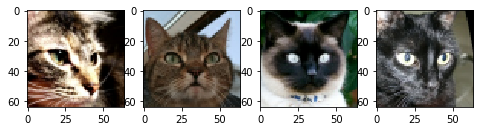

In [0]:
def preprocess_image(path):
  print(path)
  img_raw = tf.io.read_file(path)
  img_tensor = tf.image.decode_image(img_raw, channels=3, dtype=tf.float32)
  img_resized = tf.image.resize_with_pad(img_tensor, 64, 64)
  img_resized = 2*img_resized - 1
  return img_resized

FOLDER = 'catfaces'
path_list = glob.glob(os.path.join(FOLDER, '*.jpg'))

path_ds = tf.data.Dataset.from_tensor_slices(path_list)
image_ds = path_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

plt.figure(figsize=(8,2))

for idx, img in enumerate(image_ds.take(4)):
  plt.subplot(1,4, idx+1)
  print(img.shape)
#   plt.imshow((img+1)/2, cmap='gray')
  plt.imshow((img+1)/2)



#### Convolution Upsampling

From the convolutional operator output dimensionality equation:

$$O = \frac{N - F + P}{S} + 1$$

The generator model we use has 4 Conv2DTranspose layers, each doubling the output size. It begins with a 4x4 input and ends up as a 64x64 image

In [0]:
IMAGE_SIZE = (64, 64)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

class GAN:
  def __init__(self, target_size=(32, 32), channels=3, n_conv_layers=3, kernel_size=5, strides=2, input_size=100):
    self.channels = channels
    self.input_size = input_size
    self.target_size = target_size
    # Uses a power-of-2 upscaling method
    self.conv_filters = n_conv_layers
    self.kernel_size = kernel_size
    
    self._generator = self.build_generator()
    self._discriminator = self.build_discriminator()
    
    self.gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
  
  def build_generator(self):
    _x, _y = self.target_size
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(self.input_size,)))
    model.add(layers.LeakyReLU(0.15))
    model.add(layers.BatchNormalization())

    model.add(layers.Reshape((4, 4, 1024)))

    model.add(layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(self.channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    print(model.summary())
    assert model.output_shape == (None, _x, _y, self.channels)
    return model

  def build_discriminator(self):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], self.channels]))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

  @staticmethod
  def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  @staticmethod
  def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
  
  @tf.function
  def train_step(self, images):
    random_noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Automatic differentiation (one gradient for generator and one gradient for discriminator)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = self._generator(random_noise, training=True)
      
      real_output = self._discriminator(images, training=True)
      fake_output = self._discriminator(generated_images, training=True)
      
      gen_loss = self.generator_loss(fake_output)
      disc_loss = self.discriminator_loss(real_output, fake_output)
    
    generator_gradients = gen_tape.gradient(gen_loss, self._generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, self._discriminator.trainable_variables)
    
    # Each gradient mapped to a trainable variable
    self.gen_opt.apply_gradients(zip(generator_gradients, self._generator.trainable_variables))
    self.disc_opt.apply_gradients(zip(discriminator_gradients, self._discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [0]:
def train(model, epochs):
  gen_losses = []
  disc_losses = []
  
  image_ds.cache(filename='./cache.tf-data')
  batched_image_ds = image_ds.shuffle(buffer_size=64000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

  for epoch in range(epochs):
    start = time.time()
    
    i = 1
    _batch_gen_loss = 0
    _batch_disc_loss = 0
    for image_batch in batched_image_ds:
      _gl, _dl = model.train_step(image_batch)
      _batch_gen_loss = inc_mean(_batch_gen_loss, _gl, i)
      _batch_disc_loss = inc_mean(_batch_disc_loss, _dl, i)
      i += 1
    
    gen_losses.append(_batch_gen_loss)
    disc_losses.append(_batch_disc_loss)

    print ('Time for epoch {} is {} sec, with losses of {} and {}'.format(epoch + 1, time.time()-start, gen_losses[-1], disc_losses[-1]))
  return gen_losses, disc_losses

def inc_mean(current_mean, new_value, count):
  return current_mean + (new_value - current_mean)/count

In [0]:
EPOCHS = 100
BATCH_SIZE = 128
noise_dim = 100

gan = GAN(target_size=IMAGE_SIZE, channels=3)

gen_losses, disc_losses = train(gan, EPOCHS)

(None, 64, 64, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
batch_normalization_v2_7 (Ba (None, 16384)             65536     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 512)         8388608   
_________________________________________________________________
re_lu_3 (ReLU)               (None, 8, 8, 512)         0         
_________________________________________________________________
batch_normalization_v2_8 (Ba (None, 

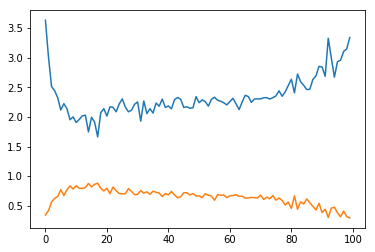

In [0]:
plt.figure()
plt.plot(gen_losses)
plt.plot(disc_losses)

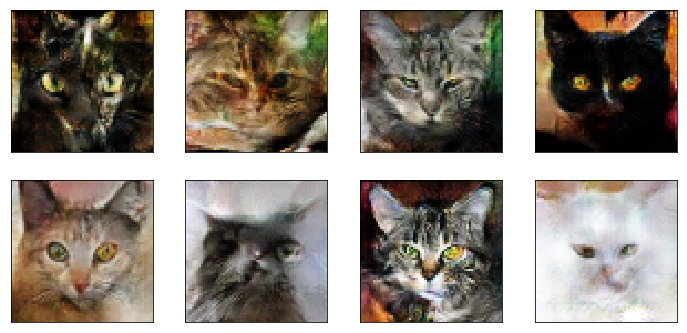

In [0]:
import numpy as np

test_generated_images = gan._generator(tf.random.normal([8, 100]), training=False)
plt.figure(figsize=(12,12))
for idx, img in enumerate(test_generated_images):
  plt.subplot(4, 4, idx + 1)
  plt.imshow((img+1)/2)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

### Saving and loading the generator and discriminator models

In [0]:
gan._discriminator.save('discriminator.h5')
gan._generator.save('generator.h5')

In [0]:
# Instantiate a new GAN object
loaded_gan = GAN(target_size=IMAGE_SIZE, channels=3)

loaded_gan._generator = tf.keras.models.load_model('generator.h5')
loaded_gan._discriminator = tf.keras.models.load_model('discriminator.h5')

(None, 64, 64, 3)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
batch_normalization_v2_14 (B (None, 16384)             65536     
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 8, 8, 512)         8388608   
_________________________________________________________________
re_lu_6 (ReLU)               (None, 8, 8, 512)         0         
_________________________________________________________________
batch_normalization_v2_15 (B (None, 

W0512 06:05:16.109511 139812857702272 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0512 06:05:16.364310 139812857702272 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


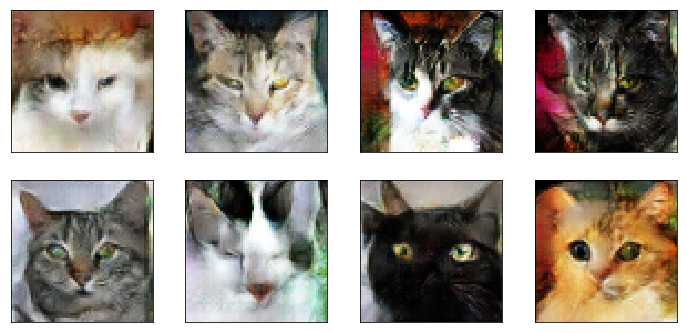

In [0]:
import numpy as np

test_generated_images = loaded_gan._generator(tf.random.normal([8, 100]), training=False)
plt.figure(figsize=(12,12))
for idx, img in enumerate(test_generated_images):
  plt.subplot(4, 4, idx + 1)
  plt.imshow((img+1)/2)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

#### Notes

1. Possible mode collapse in the ears as they all tend to have similar shape.
2. Some of the generated images look like cats overlapped on one another. More training time might be required to generate clearer images.